## Importations de package

In [144]:
import math
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color
from PIL import Image,ImageDraw
import skimage.morphology as morpho
from skimage.segmentation import watershed,mark_boundaries
import scipy.spatial as sp
import scipy.ndimage as nd

## Gradient morphologique

Text(0.5, 1.0, 'Gradient morphologique')

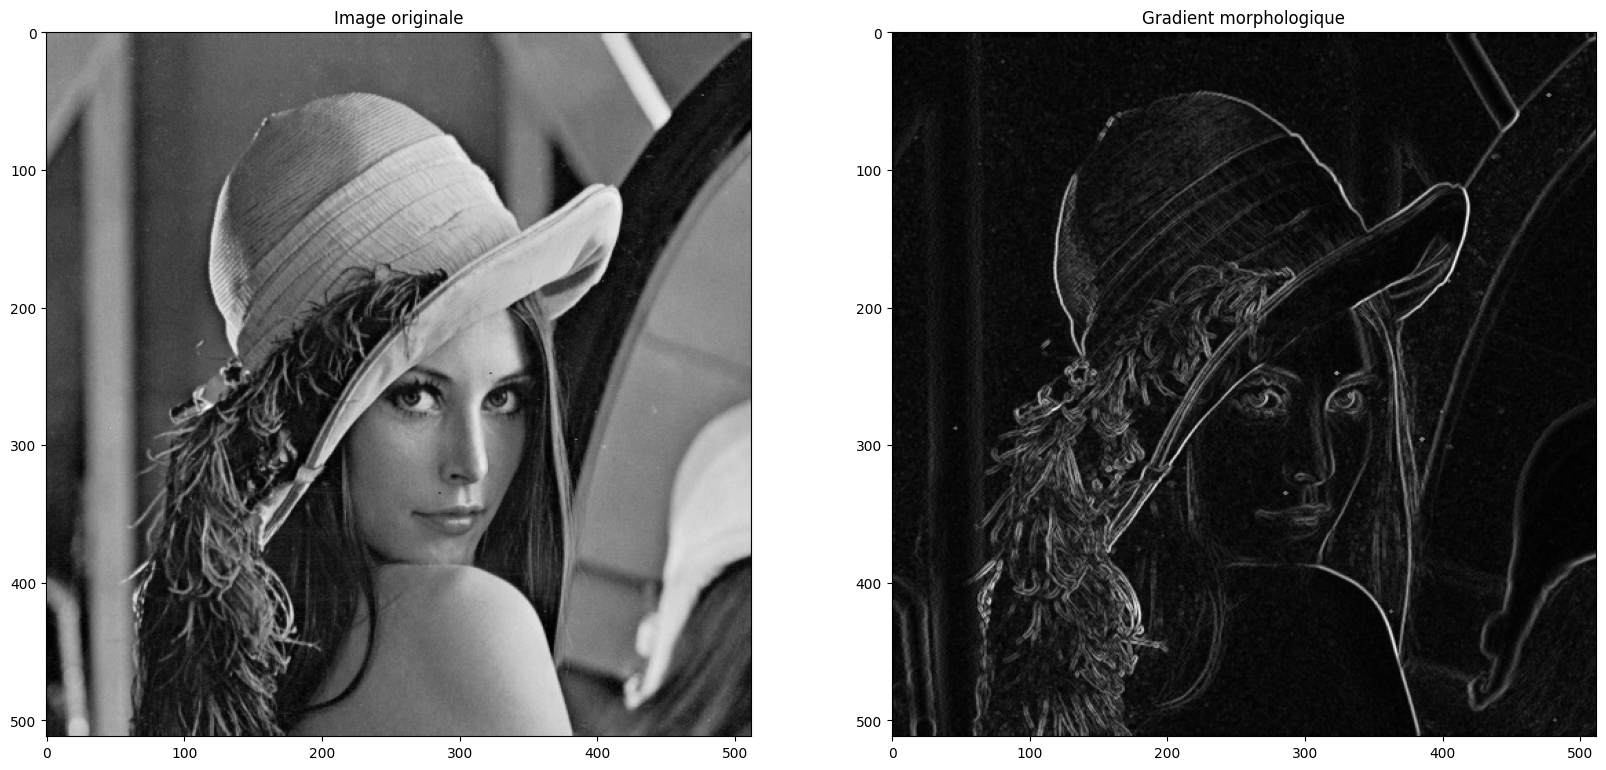

In [145]:
img = io.imread('images/lena.tif')



def gradmorpho(img):

    se = morpho.disk(1)
    morpho_grad = morpho.dilation(img,se) - morpho.erosion(img, se)

    return morpho_grad

grad_morpho = gradmorpho(img)

fig,ax = plt.subplots(1,2,figsize = (20,15))
ax[0].imshow(img,cmap='gray')
ax[0].set_title('Image originale')
ax[1].imshow(grad_morpho,cmap = "gray")
ax[1].set_title('Gradient morphologique')


## Cellules hexagonales

In [146]:
def calcul_hexa_centers(img,taille):
    colonnes, lignes = img.size
    hexa_centers = []
    p_horizontal=3*taille*0.5
    p_vertical=np.sqrt(3)*taille
    I = int(colonnes/p_horizontal) + 2 #I est le nombre de centres par ligne
    J = int(lignes/p_vertical) + 2 #J est le nombre de centres par colonne
    for i in range(I):
        for j in range(J):
            if i%2==0:
                hexa_centers.append((int(i*p_horizontal) ,int(j*p_vertical)))
            else:
                hexa_centers.append((int(i*p_horizontal),int((j*p_vertical)+p_vertical/2)))
    return hexa_centers

"""
hexa_centers = calcul_hexa_centers(img,10)
lignes, colonnes = img.shape
img_test = np.zeros((lignes,colonnes))+255
for center in hexa_centers:
    #if center[0]<lignes and center[1]<colonnes:
    img_test[center[0]][center[1]] = 0
plt.imshow(img_test,cmap='gray')
print(hexa_centers)
#hexa_contours = np.zeros((lignes,colonnes,1))
"""


"\nhexa_centers = calcul_hexa_centers(img,10)\nlignes, colonnes = img.shape\nimg_test = np.zeros((lignes,colonnes))+255\nfor center in hexa_centers:\n    #if center[0]<lignes and center[1]<colonnes:\n    img_test[center[0]][center[1]] = 0\nplt.imshow(img_test,cmap='gray')\nprint(hexa_centers)\n#hexa_contours = np.zeros((lignes,colonnes,1))\n"

In [147]:
def hexa_sommets(centre, t, rho):
    x,y = centre
    taille= t*rho
    return [(x+taille,y),
            (x+(taille/2),y+(taille*np.sqrt(3)/2)),
            (x-(taille/2),y+(taille*np.sqrt(3)/2)),
            (x-taille,y),
            (x-(taille/2),y-(taille*np.sqrt(3)/2)),
            (x+(taille/2),y-(taille*np.sqrt(3)/2))
            ]


Text(0.5, 1.0, 'rho=0.9')

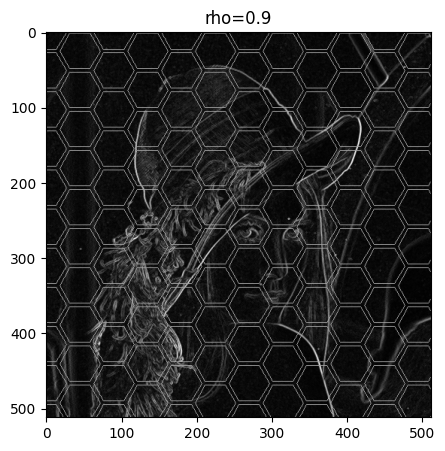

In [148]:
def hexagon_grid(img, taille, rho):
    img_grid = img.copy()
    draw = ImageDraw.Draw(img_grid)
    hexa_centers = calcul_hexa_centers(img,taille)

    for c in hexa_centers:
        p = hexa_sommets(c, taille, rho)
        draw.polygon((p),outline="gray")

    return img_grid

im = Image.fromarray(np.uint8(grad_morpho))
hexa = hexagon_grid(im,30,0.9)
fig,ax = plt.subplots(1,1,figsize=(5,5))
ax.imshow(hexa, cmap='gray')
ax.set_title('rho=0.9')


## Sélection des marqueurs

In [149]:
def point_dans_hexagon(centre,point,taille):
    x,y = point[0]-centre[0],point[1]-centre[1]
    distance = math.sqrt((x**2)+(y**2))
    if distance > 0:
        theta = math.acos(x/distance)
        theta = theta%(np.pi/3)
        distance_max=0
        if(theta<=np.pi/6):
            distance_max = taille*((((math.sqrt(3)*0.5)-1)*6*theta/np.pi)+1)
        else:
            distance_max = taille*(6*theta*(1-(math.sqrt(3)*0.5))/np.pi)+math.sqrt(3)-1
        return distance < distance_max
    else:
        return True

In [150]:
def extract_hex_points(centre,taille):
    square = []
    hex=[]
    for x in range(-taille,taille):
        for y in range(-taille,taille):
            square.append((centre[0]+x,centre[1]+y))
    for s in square:
        if(point_dans_hexagon(centre,s,taille)):
            hex.append(s)
    return hex

(45, 545)
(135, 545)
(225, 545)
(315, 545)
(405, 545)
(495, 545)
(540, 0)
(540, 51)
(540, 103)
(540, 155)
(540, 207)
(540, 259)
(540, 311)
(540, 363)
(540, 415)
(540, 467)
(540, 519)


Text(0.5, 1.0, 'Minima du gradient en blanc')

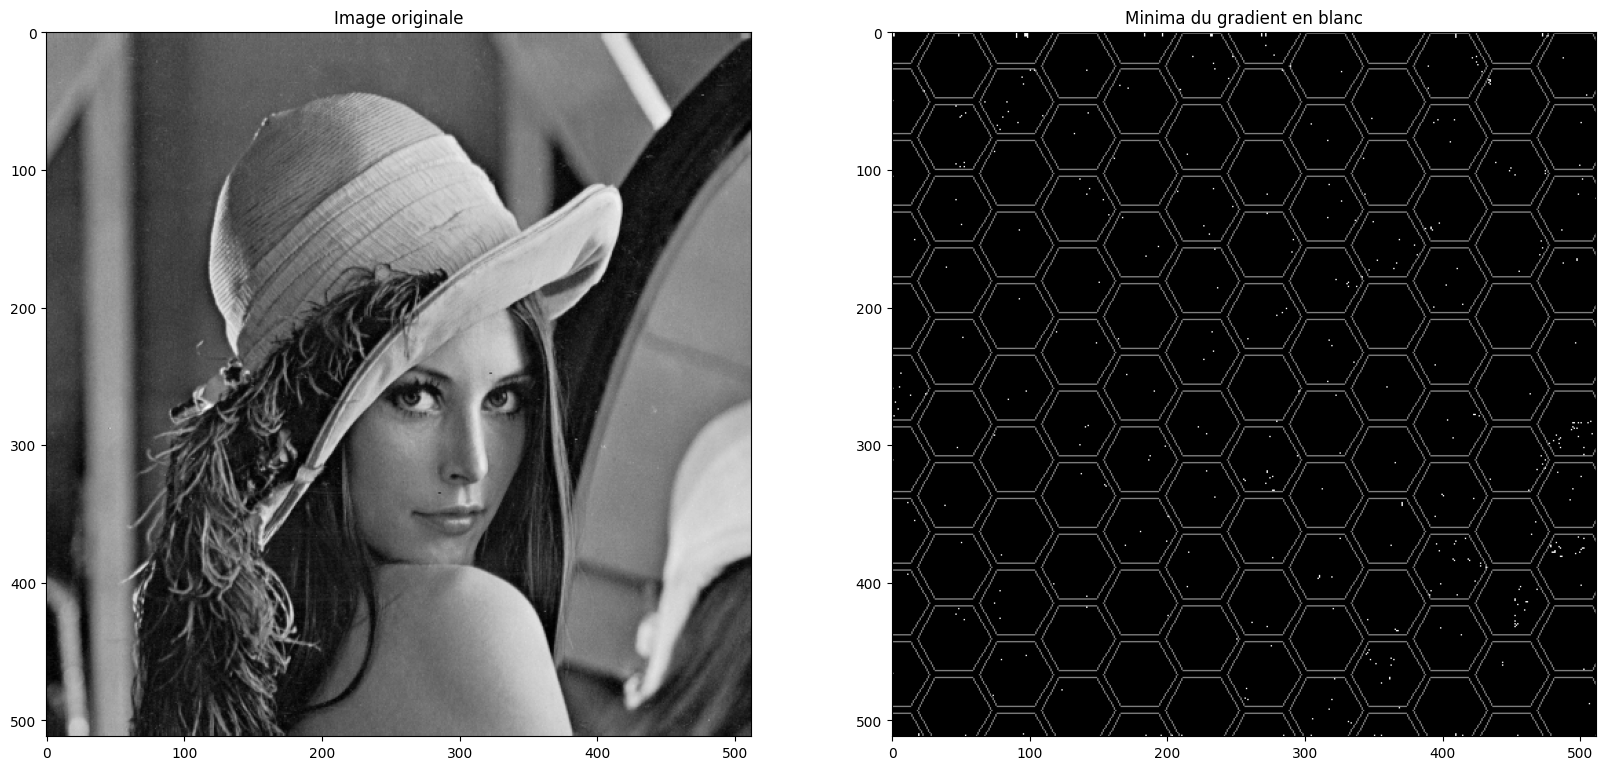

In [171]:
def extract_hex_grad_min(grad_im,c,taille):
    hex_points = extract_hex_points(c,taille)
    grad_hex = []
    grad_coord = []
    colonnes, lignes = grad_im.size
    for p in hex_points:
        if (p[0]>=0 and p[0]<lignes and p[1]>=0 and p[1]<colonnes):
            grad_hex.append(grad_im.getpixel((p[0],p[1])))
            grad_coord.append((p[0],p[1]))
    grad_hex = np.array(grad_hex)
    if len(grad_hex)>0:
        min_indices = np.where(grad_hex == grad_hex.min())[0]
        min_coord = [grad_coord[i] for i in min_indices]
        return min_coord
    else:
        return [c]

s=[]
for c in calcul_hexa_centers(im,30):
    grad_min = extract_hex_grad_min(im,c,int(30*0.9))
    s.append(grad_min)

colonnes, lignes = im.size

img_selection_marqueur = Image.new(mode='L',size=im.size,color=0)

for hexagon in s:
    for i in range(len(hexagon)):
        xy = hexagon[i]
        if xy[0]<colonnes and xy[0]>=0 and xy[1]<lignes and xy[1]>=0:
            img_selection_marqueur.putpixel(xy,255)
        else:
            print(xy)
fig,ax = plt.subplots(1,2,figsize = (20,15))

img_selection_marqueur = hexagon_grid(Image.fromarray(np.uint8(img_selection_marqueur)),30,0.9)
img_selection_marqueur.show()
ax[0].imshow(img,cmap='gray')
ax[0].set_title('Image originale')
ax[1].imshow(img_selection_marqueur,cmap = "gray")
ax[1].set_title('Minima du gradient en blanc')

In [152]:
def est_voisin(x_i,y_i,x_j,y_j):
    voisin = False
    if ((x_j==x_i+1) or(x_j==x_i-1) or (x_i==x_j)) and ((y_j==y_i+1) or y_j==y_i-1 or y_j==y_i):
        voisin = True
    return voisin

c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
[(0, 0), (0, 1), (1, 0), (1, 1), (0, 2), (1, 2), (0, 3), (1, 3)]
[(0, 50)]
[(0, 105)]
[(16, 151)]
[(4, 230)]
[(0, 259)]
[(0, 311)]
[(11, 342)]
[(11, 394)]
[(0, 466)]
[(19, 510), (19, 511)]
[(48, 1), (48, 2), (48, 3)]
[(49, 62), (50, 61)]
[(46, 122)]
[(39, 171)]
[(51, 222)]
[(47, 302)]
[(38, 344)]
[(50, 371)]
[(46, 423)]
[(53, 511)]
[(45, 545)]
[(96, 0), (96, 1), (97, 0), (97, 1), (96, 2), (97, 2), (98, 0), (98, 1), (98, 2), (96, 3), (97, 3), (98, 3), (98, 4)]
[(100, 27), (100, 28)]
[(74, 87)]
[(92, 144)]
[(92, 194)]
[(84, 267)]
[(74, 293)]
[(79, 380)]
[(74, 415)]
[(73, 482)]
[(95, 510)]
[(141, 28)]
[(132, 74)]
[(136, 107)]
[(150, 182)]
[(119, 218)]
[(136, 300)]
[(154, 329), (155, 330)]
[(117, 401)]
[(141, 418)]
[(123, 478)]
[(135, 545)]
[(183, 0), (183, 1), (183, 2), (183, 3)]
[(165, 39)]
[(161, 92)]
[(167, 135)]
[(164, 223)]
[(170, 249)]
[(186, 311)]
[(169, 373)]
[(200, 424)]
[(205, 471)]
[(184, 511)]
[(231, 1), (231, 2), (232, 1), (232, 2), (231, 3),

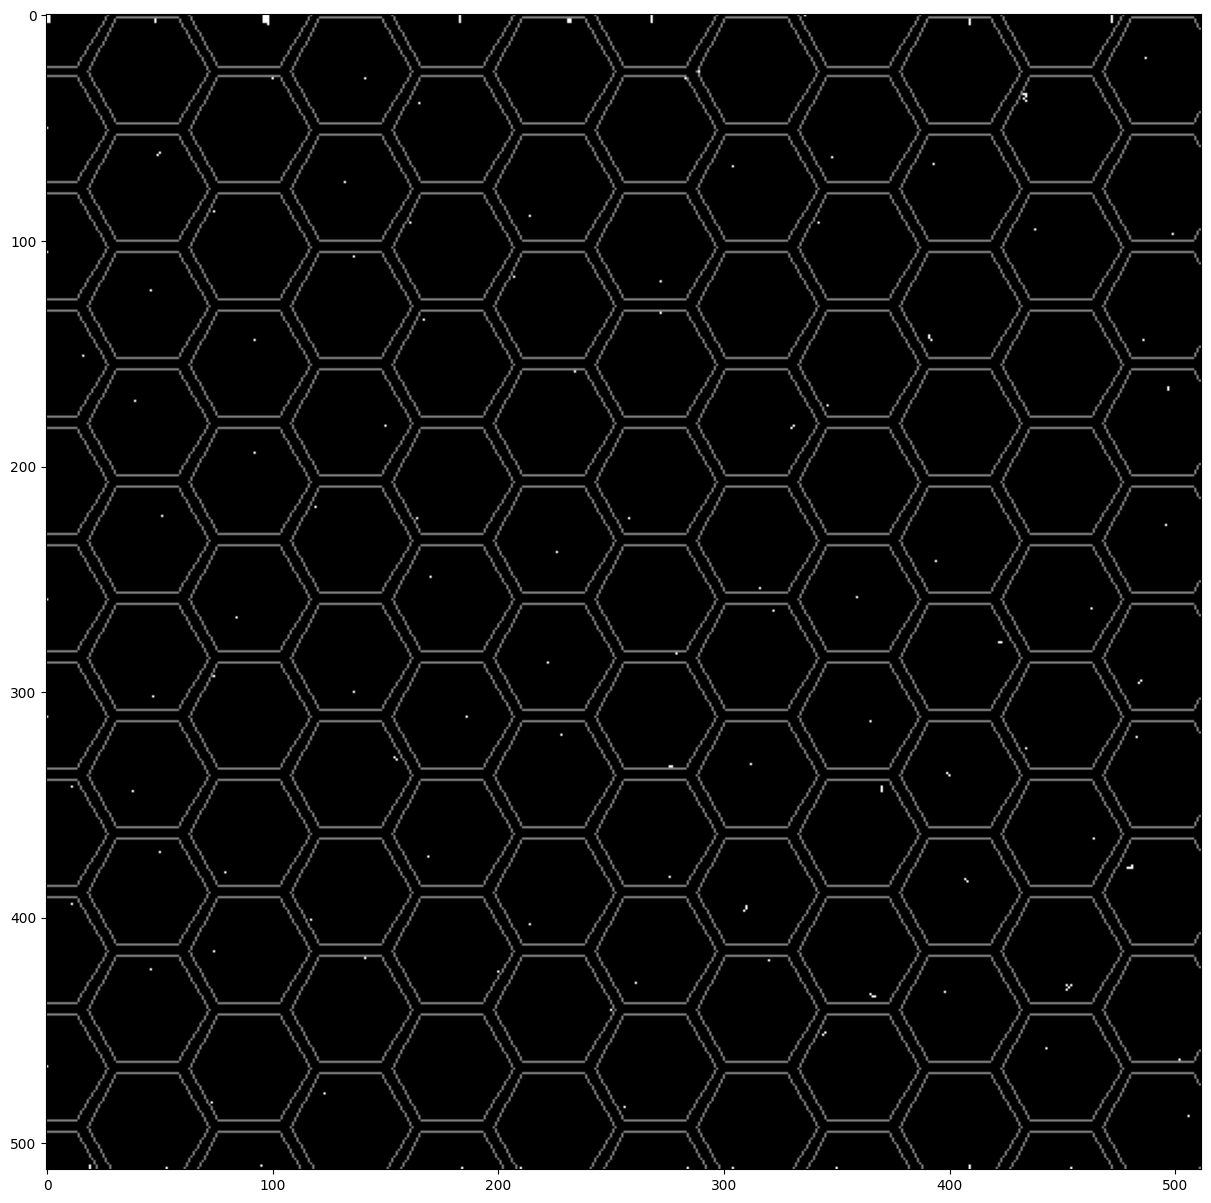

In [153]:
def selection_marqueurs(grad_im,taille,rho):
    marqueurs = []
    centres = calcul_hexa_centers(grad_im,taille)
    for c in centres:
        hex = extract_hex_grad_min(grad_im,c,int(rho*taille))
        comp = []
        while len(hex)>0:
            CC=[hex[0]]
            bl=[hex[0]]
            Attente=[]
            for s in hex:
                if s not in bl:
                    x_0,y_0 = hex[0]
                    x_s,y_s = s
                    if est_voisin(x_0,y_0,x_s,y_s):
                        Attente.append(s)
                        bl.append(s)
            while len(Attente)>0:
                sprime=Attente[0]
                for s in hex:
                    if s not in bl:
                        x_0,y_0 = sprime
                        x_s,y_s = s
                        if est_voisin(x_0,y_0,x_s,y_s):
                            Attente.append(s)
                            bl.append(s)
                Attente.remove(sprime)
                CC.append(sprime)
            comp.append(CC)
            for b in bl:
                hex.remove(b)
        max_surface = max(comp, key=len)
        marqueurs.append(max_surface)
    return marqueurs


s=selection_marqueurs(im,30,0.9)

new_temp_img = Image.new(mode="L",size=img_selection_marqueur.size,color=0)
colonnes,lignes = im.size
for grad_coord in s:
    print(grad_coord)
    for xy in grad_coord:
        if xy[0]<colonnes and xy[0]>=0 and xy[1]<lignes and xy[1]>=0:
            new_temp_img.putpixel(xy,255)


temp_hexa = hexagon_grid(Image.fromarray(np.uint8(new_temp_img)),30,0.9)
temp_hexa.show()
fig,ax = plt.subplots(1,1,figsize=(15,15))
ax.imshow(temp_hexa, cmap='gray')
